In [1]:
# python IO for ROOT files
import uproot

# to render latex in prints
from IPython.display import display, Latex

# numpy
import numpy as np

# For interactive plotting
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# %matplotlib widget

# Seaborn for plotting and styling
import seaborn as sns

# Pandas for data frame manipulation
import pandas as pd

# to get access to the pdg database 2024 version
import pdg

from utils.data_processing import (
    get_branch_entry,
    make_track_dict,
    get_all_mother_ids,
    get_process_ids,
    get_process_tex_str,
    is_signal_particle,
    get_process_name,
    get_particle_tex_name,
)

from utils.plotting import plotSTT, create_rotated_cross

PdgApi = pdg.connect(
    "sqlite:////home/nikin105/mlProject/data/pdg/pdgall-2024-v0.1.0.sqlite"
)

In [2]:
simFile = "/home/nikin105/mlProject/data/simulations/XiAntiXi/test/test_sim.root"
print("Input simulation file: ", simFile)

Input simulation file:  /home/nikin105/mlProject/data/simulations/XiAntiXi/test/test_sim.root


In [3]:
sim_tree = uproot.open(
    simFile + ":pndsim",
)

track_ids = sim_tree["STTPoint.fTrackID"].array(library="pd", entry_stop=1000)
unique_track_ids = []
for entry in track_ids:
    unique_track_ids.append(np.unique(entry))

In [4]:
signal_processes = [
    [88888, 3312],  # ppbar -> Xi-
    [88888, -3312],  # ppbar -> anti-Xi+
    [88888, 3312, -211],  # ppbar -> Xi- -> pi-
    [88888, -3312, 211],  # ppbar -> anti-Xi+ -> pi+
    [88888, 3312, 3122],  # ppbar -> Xi- -> Lambda0
    [88888, -3312, -3122],  # ppbar -> anti-Xi+ -> anti-Lambda0
    [88888, 3312, 3122, -211],  # ppbar -> Xi- -> Lambda0 -> pi-
    [88888, -3312, -3122, 211],  # ppbar -> anti-Xi+ -> anti-Lambda0 -> pi+
    [88888, 3312, 3122, 2212],  # ppbar -> Xi- -> Lambda0 -> p
    [88888, -3312, -3122, -2212],  # ppbar -> anti-Xi+ -> anti-Lambda0 -> anti-p
]

# signal_processes = [[13], [-13]]  # muon, anti-muon


signal_process_ids = [
    [0, 0],
    [0, 0, 4],
    [0, 0, 4, 4],
]

# signal_process_ids = [[0]]

In [6]:
momentum_keys = [
    "MCTrack.fPx",
    "MCTrack.fPy",
    "MCTrack.fPz",
]

pid_keys = [
    "MCTrack.fMotherID",
    "MCTrack.fSecondMotherID",
    "MCTrack.fProcess",
    "MCTrack.fPdgCode",
]

momenta = sim_tree.arrays(
    expressions=momentum_keys + pid_keys,
    library="pd",
    entry_start=0,
    entry_stop=1000,
)

for key in momentum_keys:
    momenta[key] = momenta.apply(
        lambda row: [row[key][idx] for idx in unique_track_ids[row.name]],
        axis=1,
    )

momenta["mother_ids"] = momenta.apply(
    lambda row: get_all_mother_ids(
        mother_ids=row["MCTrack.fMotherID"],
        second_mother_ids=row["MCTrack.fSecondMotherID"],
    ),
    axis=1,
)

momenta = momenta.drop(columns=["MCTrack.fMotherID", "MCTrack.fSecondMotherID"])

momenta["process_ids"] = momenta.apply(
    lambda row: [
        get_process_ids(
            process_ids=row["MCTrack.fProcess"],
            mother_ids=row["mother_ids"],
            pdg_ids=row["MCTrack.fPdgCode"],
            particle_id=particle_id,
        )
        for particle_id in unique_track_ids[row.name]
    ],
    axis=1,
)

momenta = momenta.drop(columns=["MCTrack.fProcess", "MCTrack.fPdgCode", "mother_ids"])

momenta["is_signal"] = momenta.apply(
    lambda row: [
        is_signal_particle(
            process_mc_ids=row["process_ids"][particle_id][0],
            process_ids=row["process_ids"][particle_id][1],
            signal_mc_ids=signal_processes,
            signal_process_ids=signal_process_ids,
        )
        for particle_id in range(len(row["process_ids"]))
    ],
    axis=1,
)

momenta["production_process"] = momenta.apply(
    lambda row: [
        get_process_name(process_id=row["process_ids"][particle_id][1][-1])
        for particle_id in range(len(row["process_ids"]))
    ],
    axis=1,
)

momenta["particle_name"] = momenta.apply(
    lambda row: [
        row["process_ids"][particle_id][0][-1]
        for particle_id in range(len(row["process_ids"]))
    ],
    axis=1,
)

momenta = momenta.drop(columns=["process_ids"])

momenta = momenta.explode(
    momentum_keys + ["is_signal", "production_process", "particle_name"],
    ignore_index=True,
)

momenta["pt"] = momenta.apply(
    lambda row: np.sqrt(row["MCTrack.fPx"] ** 2 + row["MCTrack.fPy"] ** 2), axis=1
)
momenta["P"] = momenta.apply(
    lambda row: np.sqrt(
        row["MCTrack.fPx"] ** 2 + row["MCTrack.fPy"] ** 2 + row["MCTrack.fPz"] ** 2
    ),
    axis=1,
)
momenta["theta"] = momenta.apply(
    lambda row: np.arctan2(row["pt"], row["MCTrack.fPz"]), axis=1
)
momenta["phi"] = momenta.apply(
    lambda row: np.arctan2(row["MCTrack.fPy"], row["MCTrack.fPx"]), axis=1
)
momenta["eta"] = momenta.apply(lambda row: -np.log(np.tan(row["theta"] / 2)), axis=1)

momenta.head(n=10)

,MCTrack.fPx,MCTrack.fPy,MCTrack.fPz,is_signal,production_process,particle_name,pt,P,theta,phi,eta
0,0.593632,0.028166,1.724211,True,Decay,2212,0.594299,1.823758,0.331927,0.047411,1.786747
1,0.247317,-0.030794,0.490043,True,Decay,-211,0.249227,0.549778,0.470489,-0.123873,1.428441
2,0.099263,0.10881,0.156254,True,Decay,-211,0.147285,0.214728,0.755857,0.831253,0.923788
3,-0.593274,0.008688,1.802893,True,Decay,-2212,0.593338,1.898018,0.317938,3.126950,1.830571
4,-0.084179,-0.008904,0.10396,True,Decay,211,0.084648,0.134063,0.683365,-3.036212,1.033861
5,-0.26416,-0.085539,0.321056,True,Decay,211,0.277664,0.424470,0.713050,-2.828435,0.987678
6,-0.028303,-0.038957,0.071053,True,Decay,-211,0.048153,0.085833,0.595608,-2.199102,1.181129
7,-0.137955,-0.207291,0.250697,False,Hadronic inelastic,211,0.249001,0.353342,0.782003,-2.157998,0.886184
8,0.123569,0.080167,-0.113947,False,Hadronic inelastic,211,0.147296,0.186226,2.229228,0.575503,-0.711916
9,-0.121339,0.002291,0.589059,True,Decay,-211,0.121360,0.601431,0.203181,3.122711,2.283356


In [11]:
momenta.query("particle_name > 10000 ")

,MCTrack.fPx,MCTrack.fPy,MCTrack.fPz,is_signal,production_process,particle_name,pt,P,theta,phi,eta
268,0.252684,0.046573,-0.21572,False,Hadronic inelastic,1000010030,0.256941,0.335490,2.269206,0.182265,-0.763272
269,0.040863,0.032562,-0.20684,False,Hadronic inelastic,1000010020,0.052250,0.213338,2.894158,0.672816,-2.084637
271,-0.275682,-0.376139,0.424605,False,Hadronic inelastic,1000020030,0.466349,0.630690,0.832217,-2.203280,0.816642
384,0.449914,-0.266028,0.893987,False,Hadronic inelastic,1000010040,0.522679,1.035571,0.529064,-0.533988,1.306078
394,0.043812,0.193473,-0.24709,False,Hadronic inelastic,1000020040,0.198372,0.316867,2.465127,1.348104,-1.044835
...,...,...,...,...,...,...,...,...,...,...,...
4599,-0.110358,0.02295,0.129282,False,Hadronic inelastic,1000010020,0.112719,0.171521,0.717063,2.936552,0.981557
4601,-0.754265,0.137635,0.160226,False,Hadronic inelastic,1000140290,0.766720,0.783283,1.364786,2.961103,0.207483
4877,-0.245158,0.131766,0.187736,False,Hadronic inelastic,1000020040,0.278324,0.335722,0.977375,2.648418,0.631670
4918,-0.12785,0.411219,0.120519,False,Hadronic interaction,1000160350,0.430635,0.447182,1.297914,1.872228,0.276333


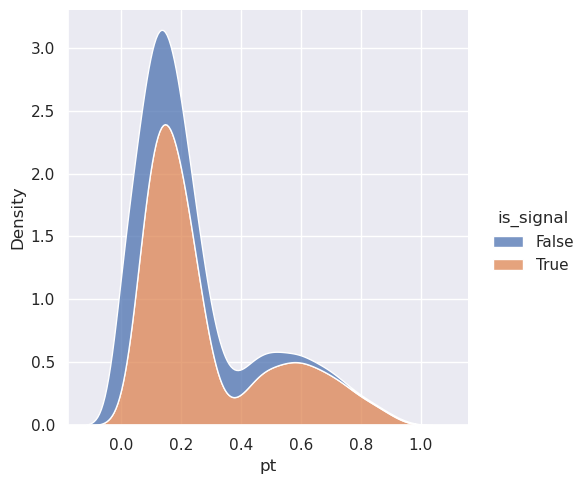

In [16]:
sns.set_theme()

sns.displot(momenta, x="pt", hue="is_signal", kind="kde", multiple="stack")